<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/hyougo/hyougo_yousei_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 2.8MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120193 sha256=23c434a2338c6b9b25ac744d753cb8a73ca9d6914cd524b1eb87bac2a10e2f10
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


In [2]:
import pathlib
import re
from urllib.parse import urljoin

In [3]:
import requests
from bs4 import BeautifulSoup

# スクレイピング

In [4]:
def get_excel(url):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, "html.parser")
    tag = soup.find("a", href=re.compile("xls[mx]?$"))

    if tag:
        link = urljoin(url, tag.get("href"))
        p = get_file(link, "data")

        return p
    else:
        raise FileNotFoundError("Excelファイルが見つかりません")

In [5]:
def get_file(url, dir="."):
    
    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [6]:
import pandas as pd

In [7]:
p = get_excel("https://web.pref.hyogo.lg.jp/kk03/corona_kanjyajyokyo.html")

df_kanja = pd.read_excel(
    p,
    skiprows=4,
    skipfooter=2,
    usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    dtype={"番号": "Int64"},
)

In [8]:
df_kanja.shape

(2534, 10)

In [9]:
df_kanja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   番号      2532 non-null   Int64 
 1   発表日     2521 non-null   object
 2   年代      2521 non-null   object
 3   性別      2521 non-null   object
 4   管轄      2521 non-null   object
 5   居住地     2521 non-null   object
 6   職業      2520 non-null   object
 7   発症日     2521 non-null   object
 8   渡航歴     2521 non-null   object
 9   備考欄     2520 non-null   object
dtypes: Int64(1), object(9)
memory usage: 200.6+ KB


In [10]:
df_kanja.count()

番号     2532
発表日    2521
年代     2521
性別     2521
管轄     2521
居住地    2521
職業     2520
発症日    2521
渡航歴    2521
備考欄    2520
dtype: int64

# 前処理

In [11]:
import datetime

import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates
import numpy as np

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [12]:
# 解像度
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [13]:
# 全列欠損を削除

df_kanja.dropna(how="all", inplace=True)

In [14]:
df_kanja

,番号,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄
2,2532,44090,40,男性,加古川,加古川健康福祉事務所管内,非公表,44085,なし,行動歴調査中
3,2531,44090,20,男性,宝塚,宝塚健康福祉事務所管内,学生,44086,なし,行動歴調査中
4,2530,44090,30,女性,宝塚,宝塚市,会社員,44087,なし,No2445の濃厚接触者
5,2529,44090,20,女性,宝塚,宝塚市,アルバイト,症状なし,なし,陽性患者の濃厚接触者
6,2528,44090,90歳以上,男性,宝塚,宝塚市,無職,44086,なし,陽性患者の濃厚接触者
...,...,...,...,...,...,...,...,...,...,...
2529,5,43896,40,男性,姫路,姫路市,会社員,43884,なし,2/19に大阪のSoap operaライブに参加
2530,4,43895,50,女性,中播磨,福崎町,無職,43883,なし,2/15、16に大阪のライブハウスArcに参加
2531,3,43893,40,女性,神戸,神戸市,会社員,43882,なし,2/15、16に大阪のライブハウスArcに参加
2532,2,43893,40,男性,神戸,神戸市,会社員,43888,なし,感染経路確認済


In [15]:
# 発表日

flg_is_serial = df_kanja["発表日"].astype("str").str.isdigit()

fromSerial = pd.to_datetime(
    df_kanja.loc[flg_is_serial, "発表日"].astype(float),
    unit="D",
    origin=pd.Timestamp("1899/12/30"),
)
fromString = pd.to_datetime(df_kanja.loc[~flg_is_serial, "発表日"])

df_kanja["発表日"] = pd.concat([fromString, fromSerial])

In [16]:
# 除外
df_kanja.set_index("番号", inplace=True)
df_kanja.dropna(thresh=2, inplace=True)

In [17]:
# 職業
df_kanja["職業"] = df_kanja["職業"].str.replace("\n", "")

In [18]:
# 備考欄

df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("\n", "")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("NO.|N0.|NO,|N0,|No,", "No.")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("・", "、")
df_kanja["備考欄"] = df_kanja["備考欄"].fillna("")

In [19]:
# ステータス

df_kanja["ステータス"] = df_kanja["発症日"].mask(df_kanja["発症日"].astype("str").str.isdigit(), "症状あり")

In [20]:
# 発症日

df_kanja["発症日"] = df_kanja["発症日"].where(df_kanja["発症日"].astype("str").str.isdigit())
df_kanja["発症日"] = pd.to_datetime(df_kanja["発症日"].astype(float), unit="D", origin=pd.Timestamp("1899/12/30"))

In [21]:
df_kanja.to_csv("kanja.tsv", sep="\t")

# 経過日数確認

## 経過日数グラフ

Text(0.98, 0.85, 'median: 6.0')

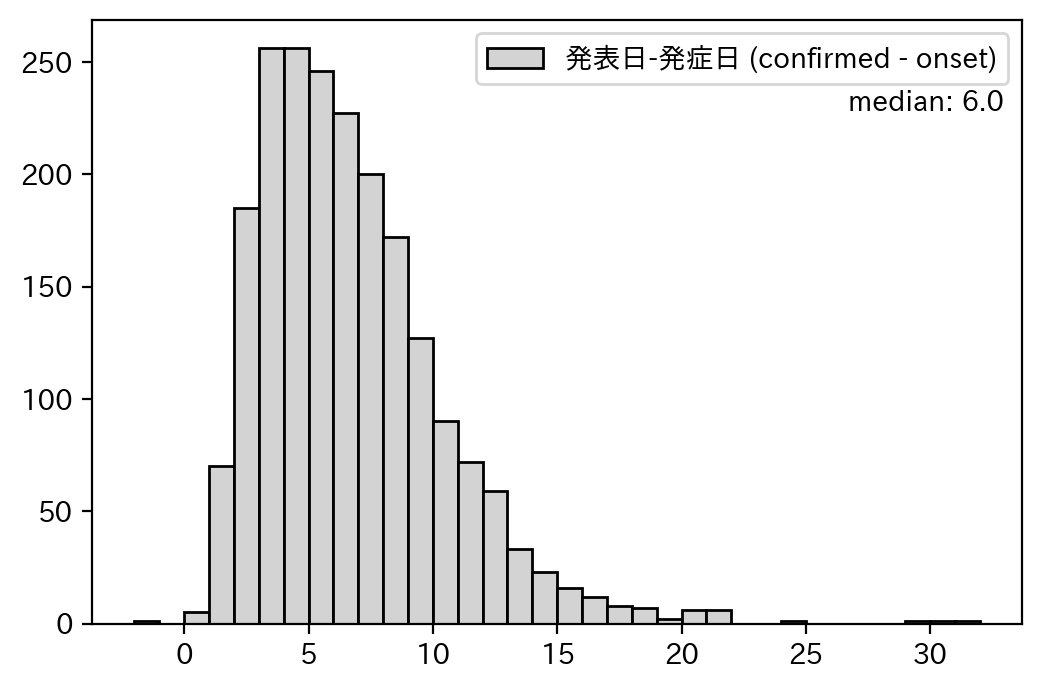

In [22]:
df_kanja["経過日数"] = (df_kanja["発表日"] - df_kanja["発症日"]).dt.days

df_kanja["経過日数"].dropna(inplace=True)

fig, ax = plt.subplots()
ax.hist(df_kanja["経過日数"], bins=np.arange(min(df_kanja["経過日数"]), max(df_kanja["経過日数"])+2), color="lightgray", edgecolor="black")
ax.legend(['発表日-発症日 (confirmed - onset)'])
ax.text(0.98, 0.85, 'median: ' + str(np.median(df_kanja["経過日数"])), horizontalalignment='right', transform=ax.transAxes)

## 経過日数一覧

In [23]:
df_kanja["経過日数"].value_counts().sort_index()

-2.0       1
 0.0       5
 1.0      70
 2.0     185
 3.0     256
 4.0     256
 5.0     246
 6.0     227
 7.0     200
 8.0     172
 9.0     127
 10.0     90
 11.0     72
 12.0     59
 13.0     33
 14.0     23
 15.0     16
 16.0     12
 17.0      8
 18.0      7
 19.0      2
 20.0      6
 21.0      6
 24.0      1
 29.0      1
 30.0      1
 31.0      1
Name: 経過日数, dtype: int64

# 発症日グラフ

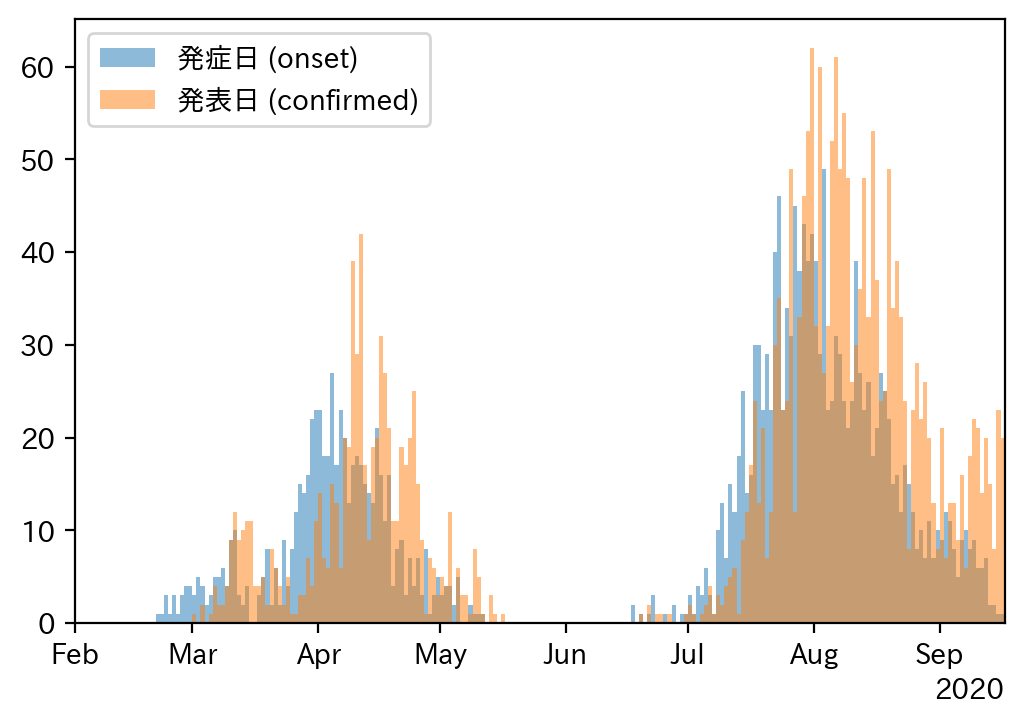

In [24]:
b = np.arange(min(min(df_kanja['発表日']), min(df_kanja['発症日'])),
              max(max(df_kanja['発表日']), max(df_kanja['発症日'])) + datetime.timedelta(days=2),
              datetime.timedelta(days=1))

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.hist(df_kanja['発症日'].values, bins=b, alpha=0.5) # edgecolor="black"
ax.hist(df_kanja['発表日'].values, bins=b, alpha=0.5)
ax.legend(['発症日 (onset)', '発表日 (confirmed)'])
ax.set_xlim(datetime.datetime(2020,2,1), b[-1])
fig.savefig('hyogo.svg', bbox_inches="tight")

# 年代確認

## 年代別グラフ

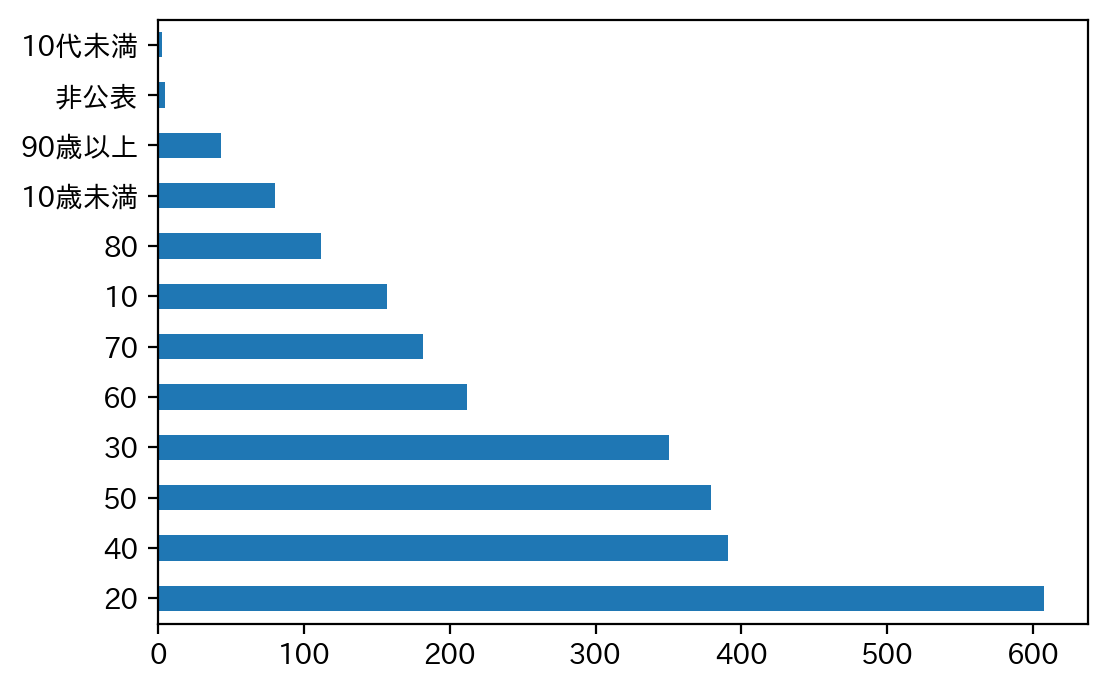

In [25]:
df_kanja["年代"].value_counts().plot.barh()

## 年代別一覧

In [26]:
df_kanja["年代"].value_counts()

20       607
40       391
50       379
30       350
60       212
70       182
10       157
80       112
10歳未満     80
90歳以上     43
非公表        5
10代未満      3
Name: 年代, dtype: int64

In [27]:
ages = ("非公表","10歳未満",10,20,30,40,50,60,70,80,90)

In [28]:
cr = pd.crosstab(df_kanja["発表日"], df_kanja["年代"], values=df_kanja["年代"], aggfunc="count").reindex(columns=ages).fillna(0).astype(int)
cr.tail(1)

年代,非公表,10歳未満,10,20,30,40,50,60,70,80,90
発表日,,,,,,,,,,,
2020-09-16,0,0,0,4,2,1,4,2,4,2,0


# 性別確認

## 性別別グラフ

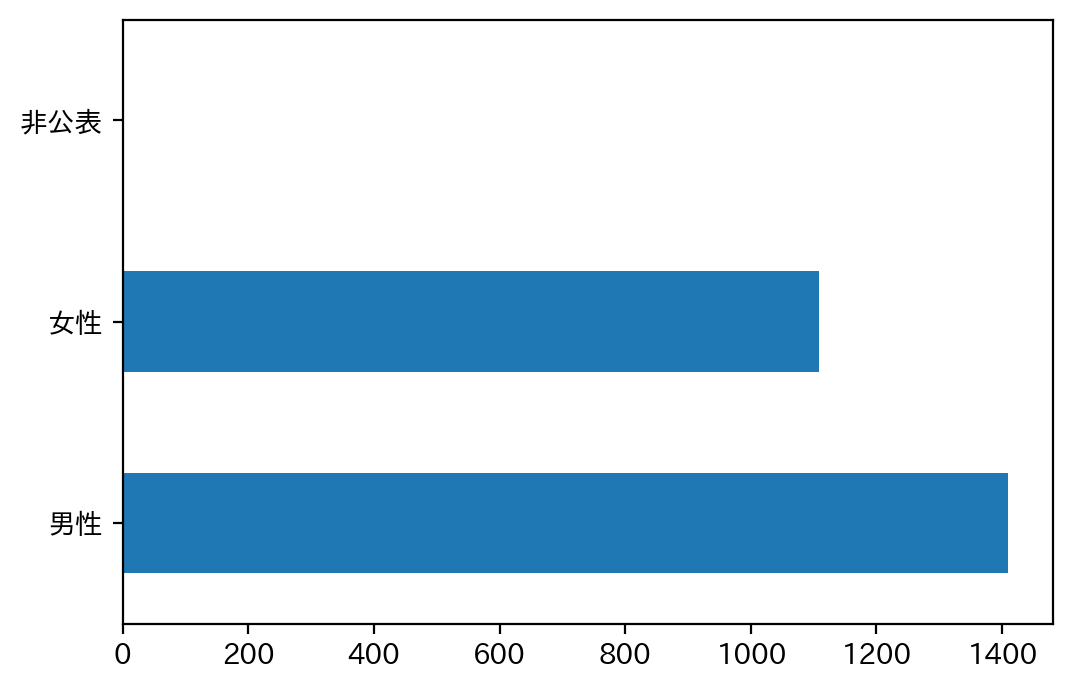

In [29]:
df_kanja["性別"].value_counts().plot.barh()

## 性別別一覧

In [30]:
df_kanja["性別"].value_counts()

男性     1410
女性     1109
非公表       2
Name: 性別, dtype: int64

# 居住地確認

## 居住地別グラフ

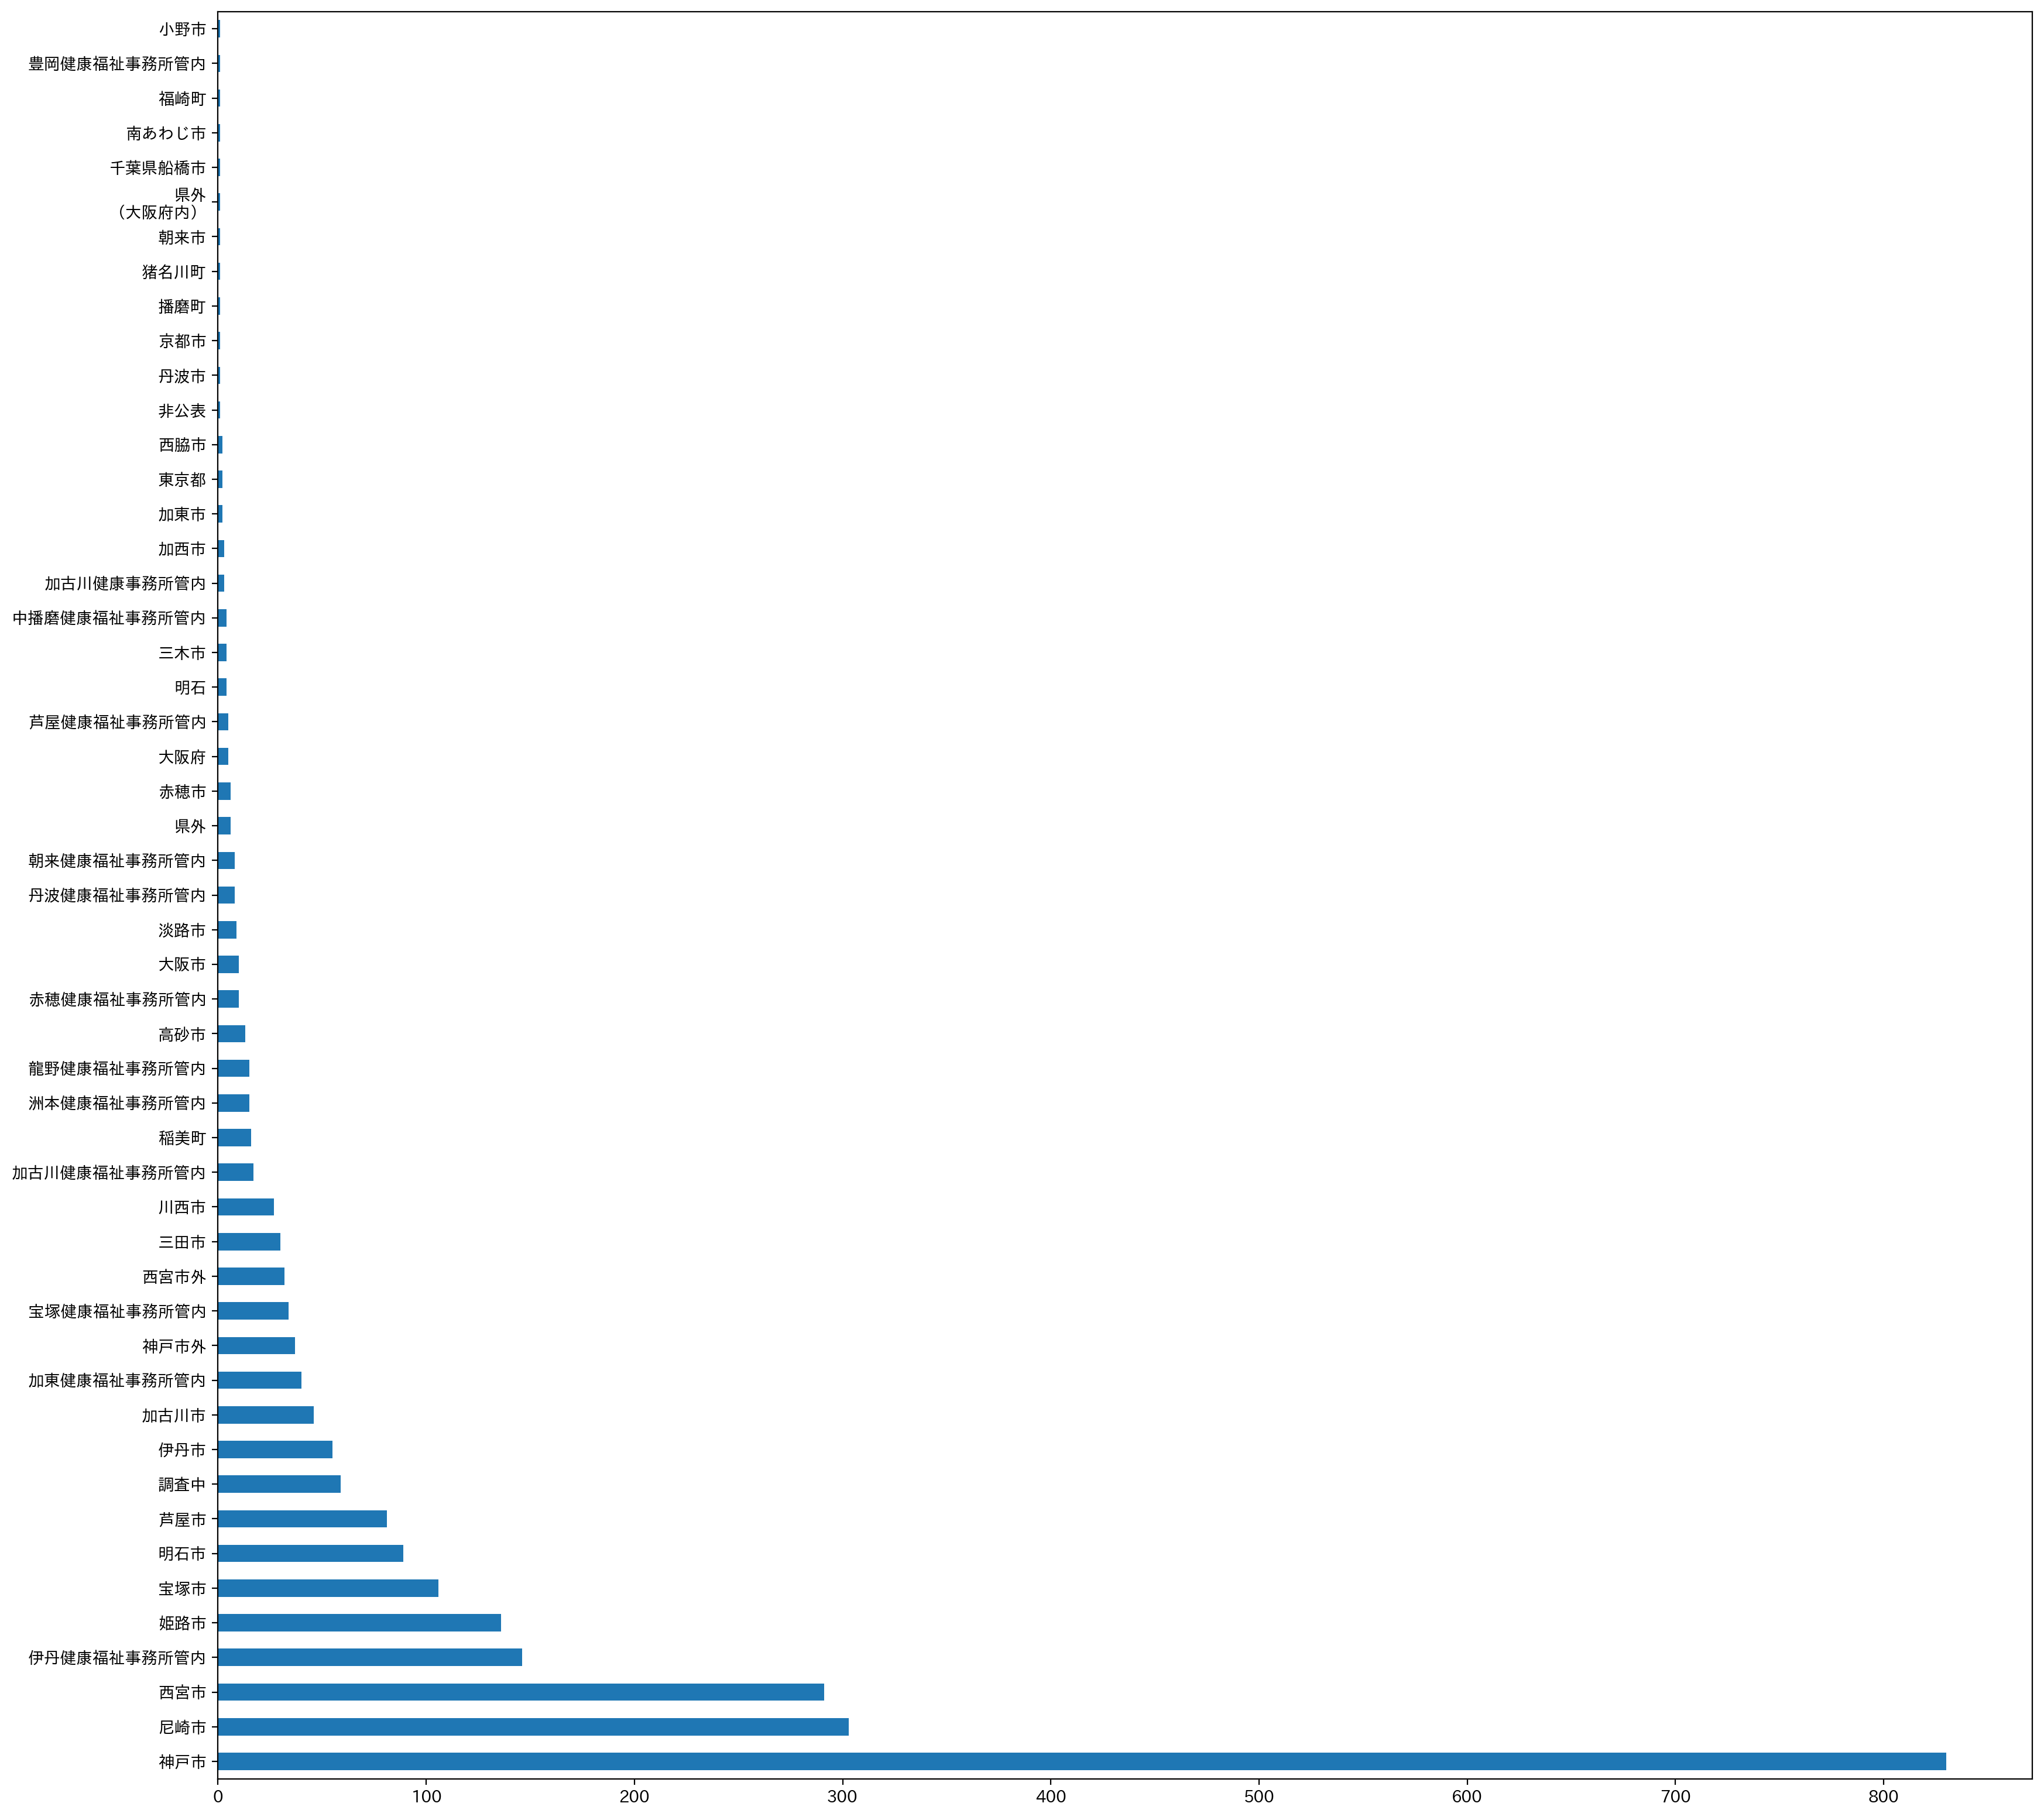

In [31]:
df_kanja["居住地"].value_counts().plot.barh(figsize=(20, 20))

## 居住地別一覧

In [32]:
df_kanja["居住地"].value_counts()

神戸市             830
尼崎市             303
西宮市             291
伊丹健康福祉事務所管内     146
姫路市             136
宝塚市             106
明石市              89
芦屋市              81
調査中              59
伊丹市              55
加古川市             46
加東健康福祉事務所管内      40
神戸市外             37
宝塚健康福祉事務所管内      34
西宮市外             32
三田市              30
川西市              27
加古川健康福祉事務所管内     17
稲美町              16
洲本健康福祉事務所管内      15
龍野健康福祉事務所管内      15
高砂市              13
赤穂健康福祉事務所管内      10
大阪市              10
淡路市               9
丹波健康福祉事務所管内       8
朝来健康福祉事務所管内       8
県外                6
赤穂市               6
大阪府               5
芦屋健康福祉事務所管内       5
明石                4
三木市               4
中播磨健康福祉事務所管内      4
加古川健康事務所管内        3
加西市               3
加東市               2
東京都               2
西脇市               2
非公表               1
丹波市               1
京都市               1
播磨町               1
猪名川町              1
朝来市               1
県外\n（大阪府内）        1
千葉県船橋市            1
南あわじ市             1
福崎町               1
豊岡健康福祉事務所管内       1


# 職業確認

## 職業別グラフ

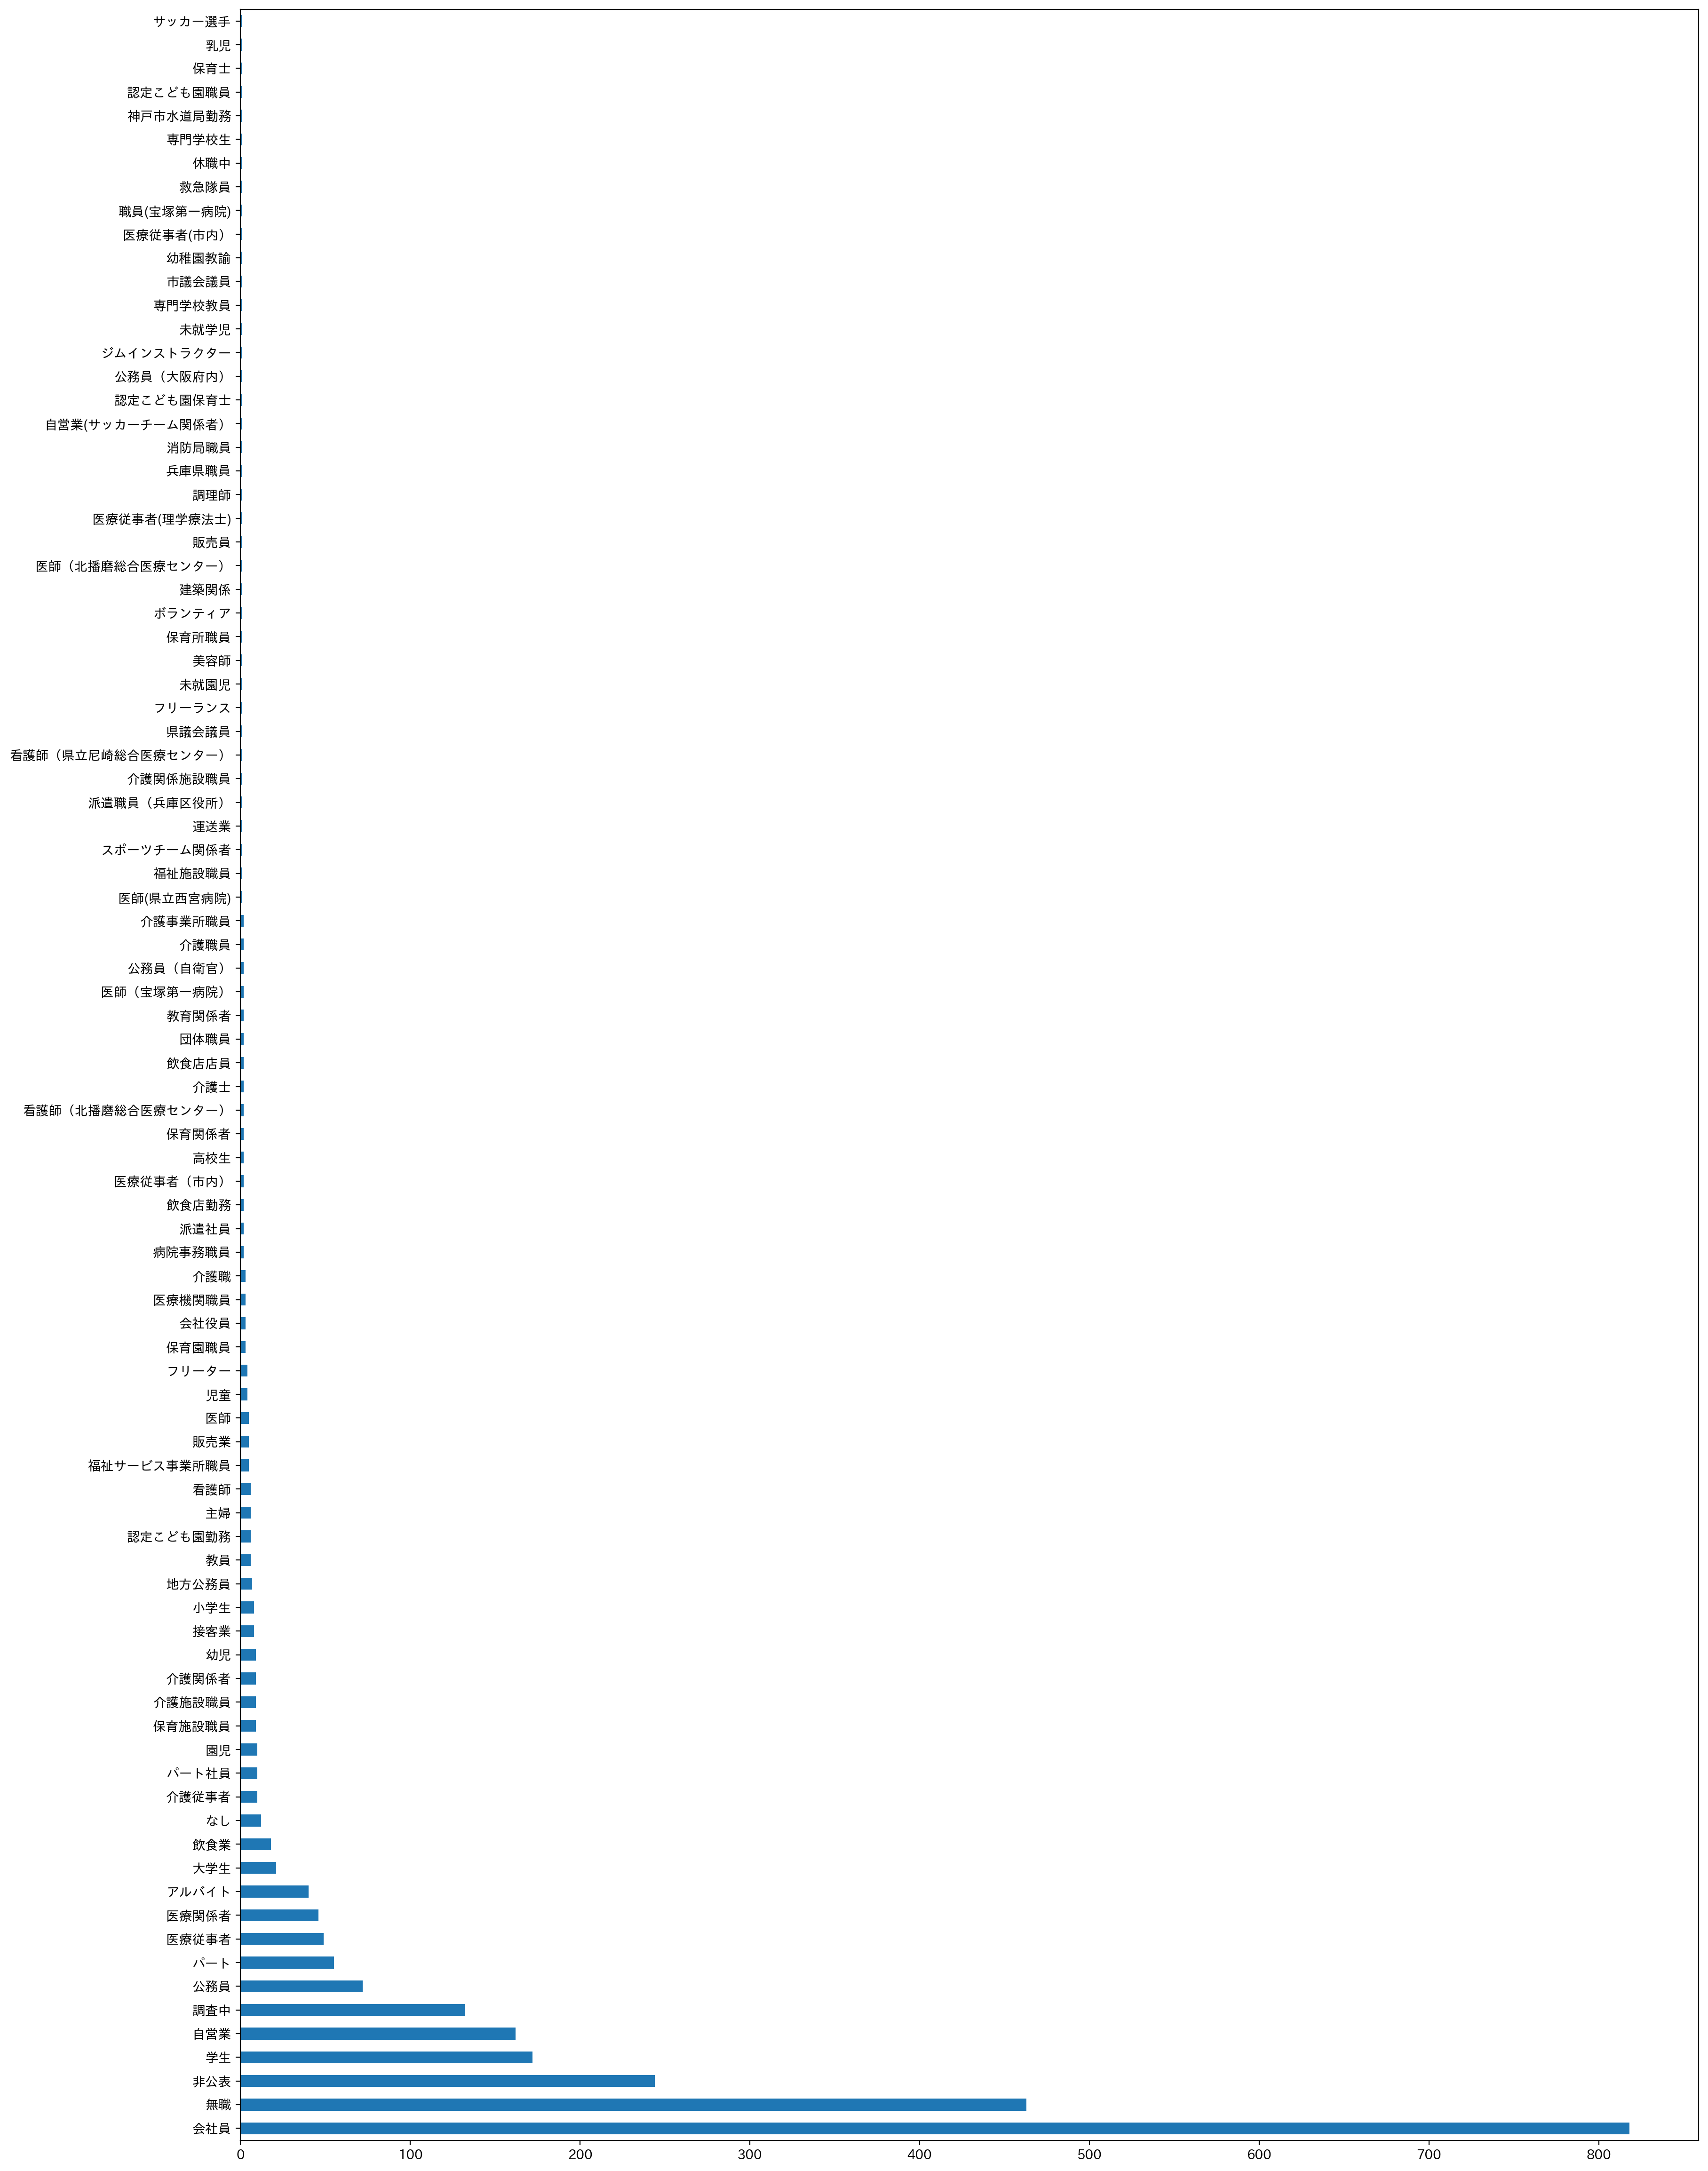

In [33]:
df_kanja["職業"].value_counts().plot.barh(figsize=(20, 30))

## 職業別一覧

In [34]:
df_kanja["職業"].value_counts()

会社員         818
無職          463
非公表         244
学生          172
自営業         162
           ... 
神戸市水道局勤務      1
認定こども園職員      1
保育士           1
乳児            1
サッカー選手        1
Name: 職業, Length: 90, dtype: int64

# 管轄確認

## 管轄別グラフ

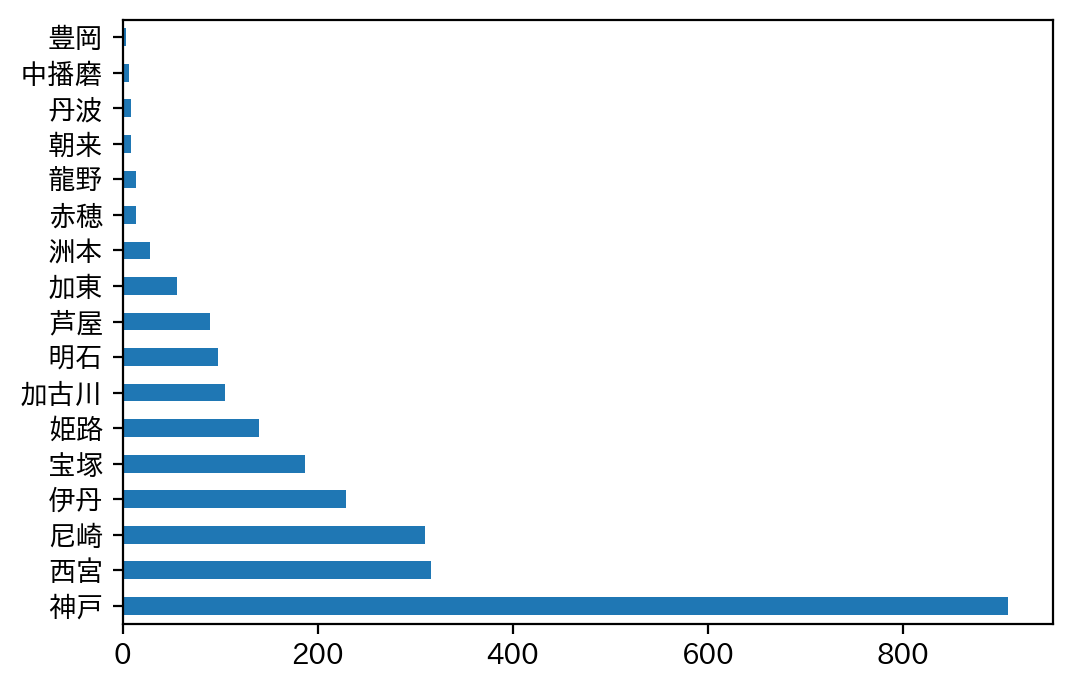

In [35]:
df_kanja["管轄"].value_counts().plot.barh()

## 管轄別一覧

In [36]:
df_kanja["管轄"].value_counts()

神戸     908
西宮     316
尼崎     310
伊丹     229
宝塚     187
姫路     140
加古川    105
明石      98
芦屋      89
加東      56
洲本      28
赤穂      14
龍野      14
朝来       9
丹波       9
中播磨      6
豊岡       3
Name: 管轄, dtype: int64

# 最新

In [37]:
cr = pd.crosstab(df_kanja["発表日"], df_kanja["管轄"], values=df_kanja["管轄"], aggfunc="count").reindex(columns=["芦屋","宝塚","伊丹","加古川","加東","中播磨","龍野","赤穂","豊岡","朝来","丹波","洲本","神戸","姫路","尼崎","西宮","明石"]).fillna(0).astype(int)
cr.tail(1)

管轄,芦屋,宝塚,伊丹,加古川,加東,中播磨,龍野,赤穂,豊岡,朝来,丹波,洲本,神戸,姫路,尼崎,西宮,明石
発表日,,,,,,,,,,,,,,,,,
2020-09-16,0,5,0,1,0,0,0,0,0,0,0,0,4,2,5,2,1


In [38]:
cr.sum(axis=1).tail(1)

発表日
2020-09-16    20
dtype: int64

# 渡航歴確認

## 渡航歴別グラフ

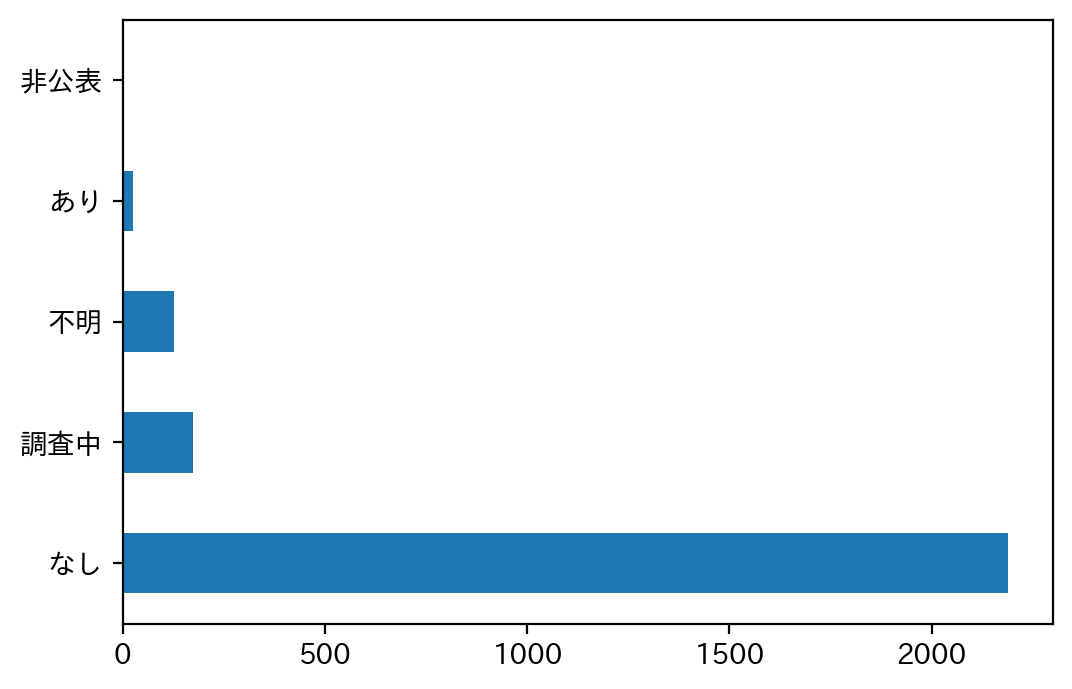

In [39]:
df_kanja["渡航歴"].value_counts().plot.barh()

## 渡航歴別一覧

In [40]:
df_kanja["渡航歴"].value_counts()

なし     2190
調査中     174
不明      127
あり       26
非公表       4
Name: 渡航歴, dtype: int64

# ステータス確認

## ステータス別グラフ

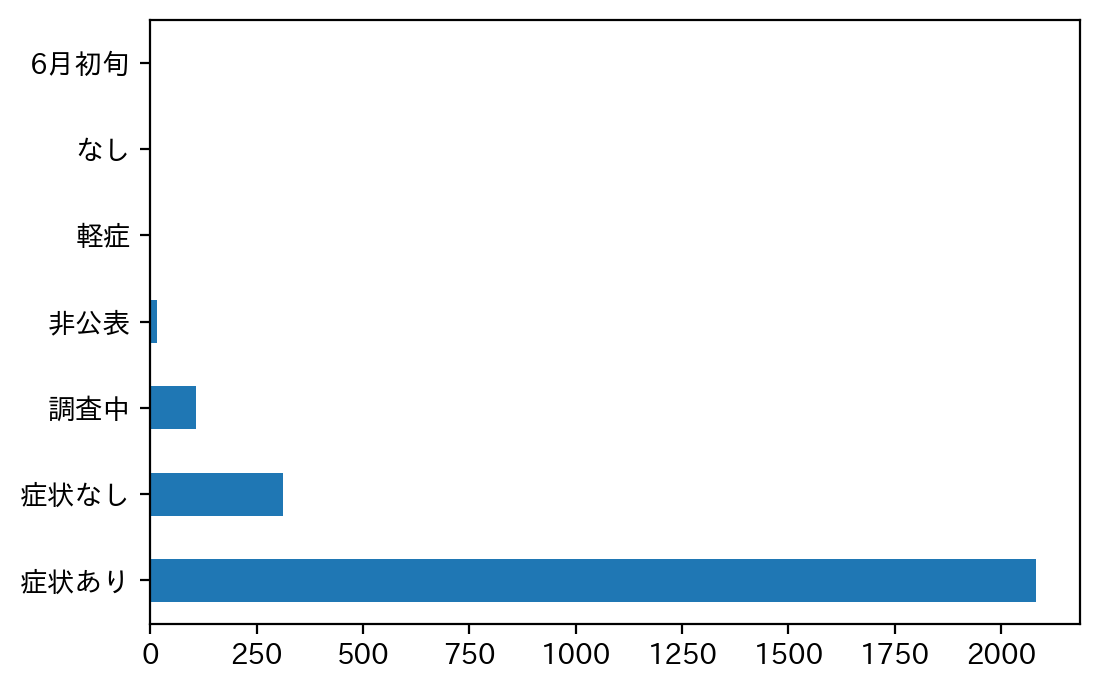

In [41]:
df_kanja["ステータス"].value_counts().plot.barh()

## ステータス別一覧

In [42]:
df_kanja["ステータス"].value_counts()

症状あり    2083
症状なし     311
調査中      107
非公表       15
軽症         2
なし         2
6月初旬       1
Name: ステータス, dtype: int64

# 全体確認

In [43]:
df_kanja

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
2532,2020-09-16,40,男性,加古川,加古川健康福祉事務所管内,非公表,2020-09-11,なし,行動歴調査中,症状あり,5.0
2531,2020-09-16,20,男性,宝塚,宝塚健康福祉事務所管内,学生,2020-09-12,なし,行動歴調査中,症状あり,4.0
2530,2020-09-16,30,女性,宝塚,宝塚市,会社員,2020-09-13,なし,No2445の濃厚接触者,症状あり,3.0
2529,2020-09-16,20,女性,宝塚,宝塚市,アルバイト,NaT,なし,陽性患者の濃厚接触者,症状なし,NaN
2528,2020-09-16,90歳以上,男性,宝塚,宝塚市,無職,2020-09-12,なし,陽性患者の濃厚接触者,症状あり,4.0
...,...,...,...,...,...,...,...,...,...,...,...
5,2020-03-06,40,男性,姫路,姫路市,会社員,2020-02-23,なし,2/19に大阪のSoap operaライブに参加,症状あり,12.0
4,2020-03-05,50,女性,中播磨,福崎町,無職,2020-02-22,なし,2/15、16に大阪のライブハウスArcに参加,症状あり,12.0
3,2020-03-03,40,女性,神戸,神戸市,会社員,2020-02-21,なし,2/15、16に大阪のライブハウスArcに参加,症状あり,11.0


# ファイル保存

In [44]:
import datetime

JST = datetime.timezone(datetime.timedelta(hours=+9))

dt_now = datetime.datetime.now(JST).date().isoformat()

## 全体

In [45]:
df_kanja.to_csv("kanja.tsv", sep="\t")

## 年齢別抽出

In [46]:
# 年齢別抽出

grouped_df = df_kanja.groupby("年代")

with pd.ExcelWriter(f"陽性者一覧（年齢別）_{dt_now}.xlsx", engine="openpyxl") as writer:

    for id in grouped_df.groups:

        d = grouped_df.get_group(id)

        # ExcelWriterを用いて新規シートにDataFrameを保存
        d.to_excel(writer, sheet_name=str(id), index=False)

# PCR

In [47]:
df_pcr = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/pcr.xlsx", index_col="年月日").fillna(0).astype(int)

In [48]:
df_pcr.rename(
    columns={
        "検査件数（合計）": "合計検査件数",
        "うち地方衛生研究所等によるPCR検査件数": "地方PCR検査件数",
        "うち民間検査機関等によるPCR検査件数": "民間PCR検査件数",
        "うち民間検査機関等による抗原検査件数": "民間抗原検査件数",
    },
    inplace=True,
)

In [49]:
df_pcr

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,
2020-01-31,2,2,0,0,0
2020-02-01,0,0,0,0,0
2020-02-02,0,0,0,0,0
2020-02-03,1,1,0,0,0
2020-02-04,0,0,0,0,0
...,...,...,...,...,...
2020-09-12,335,117,153,65,20
2020-09-13,311,77,161,73,15
2020-09-14,437,202,156,79,8


In [50]:
df_pcr.to_csv("pcr.tsv", sep="\t")

# 陽性者

In [51]:
df_yousei = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/yousei.xlsx", index_col="発表年月日")

In [52]:
df_yousei.columns

Index(['発表時間', '検査実施人数（累計）　　', '陽性者数（累計）　', '入院中（合計）', '入院中（中等症以下）', '入院中（重症）',
       '宿泊療養', '死亡（累計）', '退院（累計）'],
      dtype='object')

In [53]:
df_yousei.columns = df_yousei.columns.map(lambda s: s.replace("（累計）", "").strip())

In [54]:
df_yousei.drop("発表時間", axis=1, inplace=True)

In [55]:
df_yousei = df_yousei.fillna(0).astype(int)

In [56]:
df_yousei.to_csv("yousei.tsv", sep="\t")

In [57]:
ser = df_kanja["発表日"].value_counts().sort_index().asfreq("D").fillna(0)

In [58]:
df = df_pcr.cumsum().join(df_yousei).join(ser.cumsum()).fillna(0).astype(int)

In [59]:
df.to_csv("all.tsv", sep="\t")

# チェック

## kanjya.xlsx

### 番号

In [60]:
df_kanja[df_kanja.index.duplicated(keep=False)]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### 年代

In [61]:
df_kanja[~df_kanja["年代"].isin(["10歳未満", 10, 20, 30, 40, 50, 60, 70, 80, "90歳以上", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
401,2020-04-14,10代未満,女性,伊丹,伊丹健康福祉事務所管内,幼児,NaT,なし,No.348の濃厚接触者,症状なし,NaN
386,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0
385,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0


### 性別

In [62]:
df_kanja[~df_kanja["性別"].isin(["男性", "女性", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### 管轄

In [63]:
df_kanja[
    ~df_kanja["管轄"].isin(
        [
            "芦屋",
            "宝塚",
            "伊丹",
            "加古川",
            "加東",
            "中播磨",
            "龍野",
            "赤穂",
            "豊岡",
            "朝来",
            "丹波",
            "洲本",
            "神戸",
            "姫路",
            "尼崎",
            "西宮",
            "明石",
        ]
    )
]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### 居住地

In [64]:
df_kanja[~df_kanja["居住地"].str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "県外", "健康福祉事務所管内")) & ~(df_kanja["居住地"].isin(["調査中", "非公表"]))]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
2256,2020-08-29,40,女性,伊丹,県外\n（大阪府内）,無職,NaT,なし,No2209の濃厚接触者,症状なし,NaN
1922,2020-08-17,40,男性,明石,明石,会社員,2020-08-12,なし,行動歴調査中,症状あり,5.0
1921,2020-08-17,20,女性,明石,明石,フリーター,2020-08-03,なし,行動歴調査中,症状あり,14.0
1920,2020-08-17,20,女性,明石,明石,無職,2020-08-10,なし,No1660の濃厚接触者,症状あり,7.0
1919,2020-08-17,40,男性,明石,明石,自営業,2020-08-13,なし,行動歴調査中,症状あり,4.0
1209,2020-07-31,10,女性,加古川,加古川健康事務所管内,非公表,NaT,なし,陽性患者の濃厚接触者,症状なし,NaN
1208,2020-07-31,70,女性,加古川,加古川健康事務所管内,無職,NaT,なし,陽性患者の濃厚接触者,症状なし,NaN
1055,2020-07-28,40,女性,加古川,加古川健康事務所管内,非公表,2020-07-17,なし,陽性患者の濃厚接触者,症状あり,11.0


### 職業

In [65]:
df_kanja[df_kanja["職業"].astype(str).str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "県外", "健康福祉事務所管内"))]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### ステータス

発症日の日付以外のデータをコピー

In [66]:
df_kanja[~df_kanja["ステータス"].isin(["症状あり", "症状なし", "調査中", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1698,2020-08-12,90歳以上,女性,神戸,神戸市,無職,NaT,なし,市内介護施設の入所者,軽症,NaN
1695,2020-08-12,90歳以上,女性,神戸,神戸市,無職,NaT,なし,市内介護施設の入所者,軽症,NaN
1019,2020-07-27,20,女性,神戸,神戸市,学生,NaT,なし,感染患者（市外）の濃厚接触者,なし,NaN
931,2020-07-24,30,女性,尼崎,尼崎市,無職,NaT,なし,No926の濃厚接触者 No926，932の同居人,なし,NaN
702,2020-06-21,50,男性,西宮,西宮市外,非公表,NaT,なし,行動歴調査中,6月初旬,NaN


### 渡航歴

In [67]:
df_kanja[~df_kanja["渡航歴"].isin(["あり", "なし", "調査中", "不明", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


## pcr.xlsx

### 検査件数集計

In [68]:
df_pcr[df_pcr["合計検査件数"] != df_pcr["地方PCR検査件数"] + df_pcr["民間PCR検査件数"] + df_pcr["民間抗原検査件数"]]

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,


## yousei.xlsx

### 入院中集計

In [69]:
df_yousei[df_yousei["入院中（合計）"] != df_yousei["入院中（中等症以下）"] + df_yousei["入院中（重症）"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,
2020-09-02,45700,2303,114,101,11,33,53,2110


### 陽性者数集計

In [70]:
df_yousei[df_yousei["陽性者数"] != df_yousei["入院中（合計）"] + df_yousei["宿泊療養"] +  df_yousei["死亡"] + df_yousei["退院"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,
2020-08-14,35200,1809,221,207,14,51,48,1490
2020-08-15,35836,1862,219,205,14,60,48,1536
2020-08-16,36336,1899,225,211,14,70,48,1557
2020-08-17,36814,1923,224,213,11,56,48,1596
2020-08-18,37431,1948,224,208,16,59,48,1618
2020-08-19,38036,1997,228,210,18,59,48,1663
2020-08-20,38650,2031,227,213,14,63,48,1695
2020-08-21,39318,2070,218,204,14,59,49,1746
2020-08-22,39941,2103,225,212,13,53,49,1778


### 累計前日差チェック

In [71]:
yousei_diff = df_yousei[["検査実施人数", "陽性者数", "死亡", "退院"]].diff().fillna(0).astype(int)

In [72]:
yousei_diff[yousei_diff < 0].dropna(how='all')

,検査実施人数,陽性者数,死亡,退院
発表年月日,,,,
2020-06-29,NaN,NaN,NaN,-2.0


## pcr.xlsxとyousei.xlsx

### 陽性者数

3/9まで「yousei.xlsx」データなし

In [73]:
df.loc[df["陽性件数"] != df["陽性者数"], ["陽性件数", "陽性者数"]]

,陽性件数,陽性者数
年月日,,
2020-03-01,1,0
2020-03-02,1,0
2020-03-03,3,0
2020-03-04,3,0
2020-03-05,4,0
2020-03-06,8,0
2020-03-07,10,0
2020-03-08,12,0
2020-03-09,16,0


### 検査件数

3/9まで「yousei.xlsx」データなし

In [74]:
df.loc[df["合計検査件数"] != df["検査実施人数"], ["合計検査件数", "検査実施人数"]]

,合計検査件数,検査実施人数
年月日,,
2020-01-31,2,0
2020-02-01,2,0
2020-02-02,2,0
2020-02-03,3,0
2020-02-04,3,0
2020-02-05,3,0
2020-02-06,4,0
2020-02-07,4,0
2020-02-08,4,0


## pcr.xlsxとkanjya.xlsx

### 陽性者数

In [75]:
df.loc[df["陽性件数"] != df["発表日"], ["陽性件数", "発表日"]]

,陽性件数,発表日
年月日,,
